Predicting Usage of a Video Game Research Server
# Project Report
## Predict the number of simultaneous players on the Minecraft server for each hour of the day, using the data provided.
### Introducation



In [1]:
# importing libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Classification: Can the number of hours played during the day tell us player's experience level in players.csv.
"Can we build a classifier to predict a player's experience level using their played hours and age?"

My question: Demand forecasting: When do the most players tend to play?
Can we use start_time and end_time to predict what days players tend to play the most. 


In [2]:
set.seed(2)
sessions <- read_csv("data/sessions.csv")
players <- read_csv("data/players.csv")

# Quick look
glimpse(sessions)
glimpse(players)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 

In [3]:
# Join player data to sessions
full_data <- sessions |>
  left_join(players, by = "hashedEmail")

# Convert time columns
full_data <- full_data |>
    mutate(session_start = dmy_hm(start_time),
         session_end = dmy_hm(end_time))
# Calculate session duration
full_data <- full_data |>
  mutate(duration_mins = as.numeric(difftime(session_end, session_start, units = "mins")))

glimpse(full_data)

Rows: 1,535
Columns: 14
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ experience          <chr> "Regular", "Amateur", "Amateur", "Regular", "Amate…
$ subscribe           <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ played_hours        <dbl> 223.1, 53.9, 150.0, 223.1, 53.9, 223.1, 56.1, 178.…
$ name                <chr> "Hiroshi", "Alex", "Delara", "Hiroshi", "Alex", "H…
$ gender              <chr> "Male", "Male", "Female", "Male", "Male", "Male", …
$ Age                 <dbl> 17, 17, 16, 17, 17, 17, 23, 19, 27, 17, 23, 16, 10…
$ session_start       <dttm> 2024-06-30 18:12:00, 2024-06-17 23:33:00, 2024-07…
$ session_end   

In [4]:
full_data <- full_data |>
  mutate(hour = hour(session_start),
         wday = wday(session_start, label = TRUE))
head(full_data)

hashedEmail,start_time,end_time,original_start_time,original_end_time,experience,subscribe,played_hours,name,gender,Age,session_start,session_end,duration_mins,hour,wday
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<int>,<ord>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-06-30 18:12:00,2024-06-30 18:24:00,12,18,Sun
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,Amateur,TRUE,53.9,Alex,Male,17,2024-06-17 23:33:00,2024-06-17 23:46:00,13,23,Mon
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,Amateur,TRUE,150.0,Delara,Female,16,2024-07-25 17:34:00,2024-07-25 17:57:00,23,17,Thu
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-07-25 03:22:00,2024-07-25 03:58:00,36,3,Thu
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,Amateur,TRUE,53.9,Alex,Male,17,2024-05-25 16:01:00,2024-05-25 16:12:00,11,16,Sat
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,Regular,TRUE,223.1,Hiroshi,Male,17,2024-06-23 15:08:00,2024-06-23 17:10:00,122,15,Sun


In [5]:
full_data <- full_data |>
  mutate(
    Age = as.numeric(scale(Age)),
    played_hours = as.numeric(scale(played_hours)) 
  )
head(full_data)

hashedEmail,start_time,end_time,original_start_time,original_end_time,experience,subscribe,played_hours,name,gender,Age,session_start,session_end,duration_mins,hour,wday
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dttm>,<dbl>,<int>,<ord>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,Regular,TRUE,1.5176196,Hiroshi,Male,-0.4971942,2024-06-30 18:12:00,2024-06-30 18:24:00,12,18,Sun
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,Amateur,TRUE,-0.5444023,Alex,Male,-0.4971942,2024-06-17 23:33:00,2024-06-17 23:46:00,13,23,Mon
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,Amateur,TRUE,0.6267579,Delara,Female,-0.7086223,2024-07-25 17:34:00,2024-07-25 17:57:00,23,17,Thu
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,Regular,TRUE,1.5176196,Hiroshi,Male,-0.4971942,2024-07-25 03:22:00,2024-07-25 03:58:00,36,3,Thu
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,Amateur,TRUE,-0.5444023,Alex,Male,-0.4971942,2024-05-25 16:01:00,2024-05-25 16:12:00,11,16,Sat
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,Regular,TRUE,1.5176196,Hiroshi,Male,-0.4971942,2024-06-23 15:08:00,2024-06-23 17:10:00,122,15,Sun


Since you’re doing demand forecasting:
Create labels like high-demand (1) / low-demand (0)

In [6]:
full_data_summary <- full_data |>
  group_by(hour, wday) |>
  summarise(player_count = n(), .groups = "drop") 

threshold <- full_data_summary |>
  pull(player_count) |>
  quantile(0.75)

full_data_summary <- full_data_summary |>
  mutate(high_demand = ifelse(player_count > threshold, 1, 0))

tail(full_data_summary)

hour,wday,player_count,high_demand
<int>,<ord>,<int>,<dbl>
23,Mon,29,1
23,Tue,12,0
23,Wed,22,1
23,Thu,14,0
23,Fri,11,0
23,Sat,19,1


In [7]:
data_summary <- full_data_summary |>
    mutate(wday_num = as.numeric(wday)) |>
    select(hour, wday_num, high_demand)
tail(data_summary)

hour,wday_num,high_demand
<int>,<dbl>,<dbl>
23,2,1
23,3,0
23,4,1
23,5,0
23,6,0
23,7,1


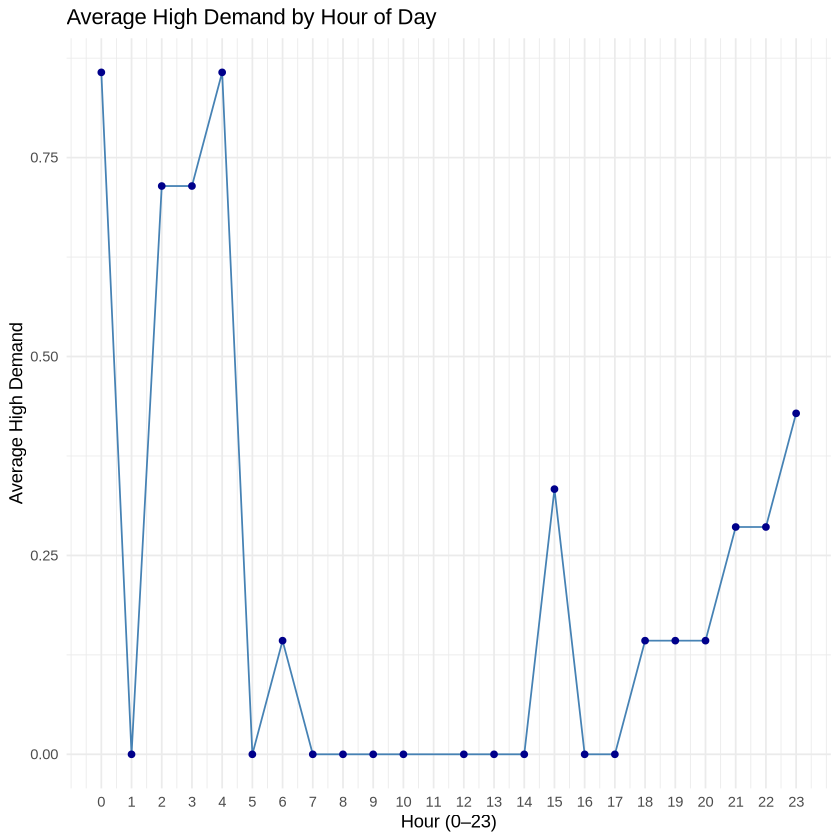

In [8]:
data_summary_plot <- data_summary |>
  group_by(hour) |>
  summarise(avg_demand = mean(high_demand, na.rm = TRUE)) |>
  ggplot(aes(x = hour, y = avg_demand)) +
  geom_line(color = "steelblue") +
  geom_point(color = "darkblue") +
  labs(title = "Average High Demand by Hour of Day",
       x = "Hour (0–23)", y = "Average High Demand") +
  scale_x_continuous(breaks = 0:23) +
  theme_minimal()
data_summary_plot

In [9]:
data_summary <- data_summary |>
    mutate(high_demand = as_factor(high_demand))
tail(data_summary)

hour,wday_num,high_demand
<int>,<dbl>,<fct>
23,2,1
23,3,0
23,4,1
23,5,0
23,6,0
23,7,1


In [10]:
set.seed(2)
data_split <- initial_split(data_summary, prop = 0.8, strata = high_demand)
train_data <- training(data_split)
test_data <- testing(data_split)

# --- 3. Create the preprocessing recipe ---
knn_recipe <- recipe(high_demand ~ hour + wday_num, data = train_data) |>
  step_scale(all_predictors()) |> 
  step_center(all_predictors())         

# --- 4. Specify the k-NN model ---
knn_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

# --- 5. Create the workflow ---
knn_fit <- workflow() |>
  add_model(knn_model) |>
  add_recipe(knn_recipe) |>
  fit(data = train_data)

# --- 7. Predict on test set ---
knn_preds <- predict(knn_fit, test_data) |>
  bind_cols(test_data)
  
knn_accuracy <- knn_preds |>
  metrics(truth = high_demand, estimate = .pred_class) |>
  filter(.metric == "accuracy") 

knn_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8214286


In [11]:
precision <- knn_preds |>
  precision(truth = high_demand, estimate = .pred_class)
precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8636364


In [12]:
recall <- knn_preds |>
  recall(truth = high_demand, estimate = .pred_class)
recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9047619


In [13]:
confusion <- knn_preds |>
             conf_mat(truth = high_demand, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 19  3
         1  2  4

In [14]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = 1:10)
# --- 5. Create the workflow ---
knn_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(knn_recipe) 

knn_results <- knn_worklow

In [ ]:
data_split <- initial_split(players_train, prop = 0.75, strata = experience)
players_subtrain <- training(data_split)
players_validation <- testing(data_split)

# recreate the standardization recipe from before
# (since it must be based on the training data)
recipe <- recipe(experience ~ .,
                        data = players_subtrain) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  fit(data = players_subtrain)

# get predictions on the validation data
validation_predicted <- predict(knn_fit, players_validation) |>
  bind_cols(players_validation)

# compute the accuracy
acc <- validation_predicted |>
  metrics(truth = experience, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()

acc

In [ ]:
players_train
# cross-validation with 5 folds
players_vfold <- vfold_cv(players_train, v = 5, strata = experience)
players_vfold


In [ ]:
# Tidy data and select the columns you want to train your model on
project <- combined_data |>
    select(name, start_time, end_time)
head(project)

 Classification Problem
Question:

Can we predict whether a 30-minute time window will experience high demand (more than 60 players) based on features like day of week, time of day, and other contextual variables?

Regression Problem
Question:

Can we predict the exact number of players in a 30-minute window?

Target variable: player_count (numeric)
Predictors: Same as above